# Computational Graphs Exercise

In [1]:
from typing import List, Optional
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


## Nodes implementations (from last year exercise)
- Note: If you want a good challenge, try to implement this yourself. 
    - Link: [Old Exercise 3](https://github.com/trusthlt/nlp-with-deep-learning-lectures/tree/main/exercises/archive24/ex03)

In [2]:
class ScalarNodeCache:
    def __init__(self):
        self.value: Optional[float] = None
        self.local_partial_derivatives_wrt_arguments: Optional[List[float]] = None
        self.global_derivative_wrt_self: Optional[float] = None

class ScalarNode:

    def __init__(self, arguments: List['ScalarNode']) -> None:
        self._parents: List['ScalarNode'] = []
        self._arguments = arguments
        for arg in self._arguments:
            arg._parents.append(self)
        self._cache = ScalarNodeCache()

    def value(self) -> float:
        raise NotImplementedError()

    def local_partial_derivatives_wrt_arguments(self) -> List[float]:
        raise NotImplementedError()

    def find_self_position_in_parents_arguments(self, parent: 'ScalarNode') -> int:
        for i, arg in enumerate(parent._arguments):
            if self == arg:
                return i
        raise Exception("Self found not in parent's arguments")

    def global_derivative_wrt_self(self) -> float:
        # caching for efficiency
        if self._cache.global_derivative_wrt_self is not None:
            return self._cache.global_derivative_wrt_self

        if len(self._parents) == 0:
            # output node: derivative of output wrt itself is 1.0
            return 1.0
        else:
            result = 0.0
            # generalized chain rule: sum over parents of (d parent / d self) * (global d output / d parent)
            for p in self._parents:
                idx = self.find_self_position_in_parents_arguments(p)
                parent_to_self = p.local_partial_derivatives_wrt_arguments()[idx]
                parent_global = p.global_derivative_wrt_self()
                result += parent_to_self * parent_global

            self._cache.global_derivative_wrt_self = result
            return result

    def clear_cache_downwards(self):
        # Clear caches for this node and all descendant argument nodes.
        visited = set()
        stack = [self]
        while stack:
            n = stack.pop()
            if id(n) in visited:
                continue
            visited.add(id(n))
            # reset cache fields
            if hasattr(n, '_cache') and n._cache is not None:
                n._cache.value = None
                n._cache.local_partial_derivatives_wrt_arguments = None
                n._cache.global_derivative_wrt_self = None
            for a in getattr(n, '_arguments', []):
                stack.append(a)

    def __repr__(self):
        return f'<{self.__class__.__name__} at {hex(id(self))}>'

class ConstantNode(ScalarNode):

    def __init__(self, value: float) -> None:
        super().__init__([])
        self._value = value

    def value(self) -> float:
        return self._value

    def local_partial_derivatives_wrt_arguments(self) -> List[float]:
        return []



class SumNode(ScalarNode):

    def value(self) -> float:
        if self._cache.value is not None:
            return self._cache.value
        result = 0.0
        for arg in self._arguments:
            result += arg.value()
        self._cache.value = result
        return result

    def local_partial_derivatives_wrt_arguments(self) -> List[float]:
        # derivative wrt each argument is 1.0
        return [1.0] * len(self._arguments)

class ProductNode(ScalarNode):

    def value(self) -> float:
        if self._cache.value is not None:
            return self._cache.value
        result = 1.0
        for arg in self._arguments:
            result *= arg.value()
        self._cache.value = result
        return result

    def local_partial_derivatives_wrt_arguments(self) -> List[float]:
        if self._cache.local_partial_derivatives_wrt_arguments is not None:
            return self._cache.local_partial_derivatives_wrt_arguments
        result = [0.0] * len(self._arguments)
        for i in range(len(self._arguments)):
            ith = 1.0
            for j in range(len(self._arguments)):
                if i != j:
                    ith *= self._arguments[j].value()
            result[i] = ith
        self._cache.local_partial_derivatives_wrt_arguments = result
        return result


# A function we will be using to visualize things!
- Here's a quick summary of how to use the draw_graph function:
    - Basic Usage:
        ```py
        draw_graph(root, use_full_labels=True, figsize=(6,4))
        ```
    - Parameters:
        - `root`: The root node of your computational graph
        - `use_full_labels`:
            - `True`: Shows full expressions with values (e.g., "s = a+b (5.5)")
            - `False`: Shows simplified labels with values (e.g., "s (5.5)")
        - `figsize`: Tuple for plot size (width, height) in inches
    - Node Colors:
        - Orange: Root node
        - Light Blue: Constant nodes
        - Light Green: Operation nodes (Sum, Product)
- You can refactor it, to change colors, the info displayed for each node etc...


In [3]:
def draw_graph(root, use_full_labels=True, figsize=(6,4)):
    G = nx.DiGraph()
    visited = set()
    stack = [root]
    node_info = {}  
    node_dict = {} 
    
    while stack:
        n = stack.pop()
        if id(n) in visited:
            continue
        visited.add(id(n))
        
        node_dict[id(n)] = n
        
        if hasattr(n, '_name'):
            if use_full_labels:
                if isinstance(n, ConstantNode):
                    label = f"{n._name} ({n._value:.1f})"
                elif isinstance(n, SumNode):
                    args = [f"{a._name if hasattr(a, '_name') else '?'}" for a in n._arguments]
                    label = f"{n._name} = " + '+'.join(args)
                    try:
                        val = n.value()
                        label += f" ({val:.1f})"
                    except:
                        pass
                elif isinstance(n, ProductNode):
                    args = [f"{a._name if hasattr(a, '_name') else '?'}" for a in n._arguments]
                    label = f"{n._name} = " + '*'.join(args)
                    try:
                        val = n.value()
                        label += f" ({val:.1f})"
                    except:
                        pass
            else:
                if isinstance(n, ConstantNode):
                    label = f"{n._name} ({n._value:.1f})"
                else:
                    try:
                        val = n.value()
                        label = f"{n._name} ({val:.1f})"
                    except:
                        label = n._name
        else:
            label = f"Node_{id(n)}"
        
        node_info[id(n)] = label
        G.add_node(id(n))
        for a in getattr(n, '_arguments', []):
            G.add_edge(id(a), id(n))
            stack.append(a)
    
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)
    
    node_colors = []
    for node in G.nodes():
        if node == id(root):
            node_colors.append('orange')
        elif isinstance(node_dict[node], ConstantNode):
            node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')
    
    nx.draw(G, pos, with_labels=False, 
            node_color=node_colors,
            node_size=1000, arrows=True)
    
    pos_attrs = {}
    for node, coords in pos.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.085)
    nx.draw_networkx_labels(G, pos_attrs, node_info, font_size=12)
    
    plt.axis('off')
    return G

### Exercise 1: Simple function
1. Create two constant nodes $a$ and $b$, then create a sum node $s=a+b$
2. In the Markdown Cell below, calculate the partial derivatives of $s$ wrt to $a$ and $b$. Calculate the global derivatives too.
3. Print the partial derivatives of $s$ wrt to $a$ and $b$
4. Using the `draw_graph` function above, try to visualize the computational graph of $s=a+b$

Note: Use the values $a=2.0$ and $b=3.5$

### Your Solution for 2. goes here:


**2.: Solve me**

Given:
$s = a + b$

**Partial derivatives:**
$\frac{\partial s}{\partial a} = 1$
$\frac{\partial s}{\partial b} = 1$

**Global derivatives:**
$\frac{ds}{da} = 1$
$\frac{ds}{db} = 1$


### Your solutions for 1., 3. and 4. should go below:

sum value = 5.5
partial derivative wrt a = 1.0
partial derivative wrt b = 1.0
global derivative a= 1.0
global derivative b= 1.0


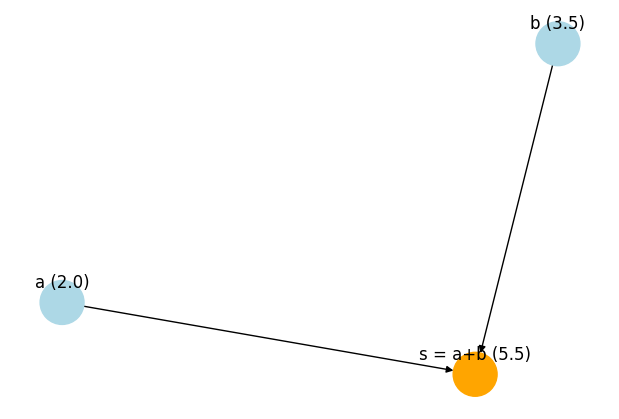

In [4]:
# constants
a = ConstantNode(2.0)
b = ConstantNode(3.5)
s = SumNode([a, b])

a._name = 'a'
b._name = 'b'
s._name = 's'
# compute value (caching behind the scenes)
print('sum value =', s.value())  # expected 5.5

# local partials
partial_a, partial_b = s.local_partial_derivatives_wrt_arguments()
print('partial derivative wrt a =', partial_a)  # expected 1.0
print('partial derivative wrt b =', partial_b)  # expected 1.0

# global derivative of the constants wrt output
print('global derivative a=', a.global_derivative_wrt_self())
print('global derivative b=', b.global_derivative_wrt_self())

draw_graph(s)
plt.show()


### Exercise 2: Still a simple function
1. Create 3 constant nodes $a$, $b$ and $c$, then create a product node $p=a\cdot b\cdot c$
2. In the Markdown Cell below, calculate the partial derivatives of $p$ wrt to $a$, $b$ and $c$. Calculate the global derivatives too.
3. Print the partial derivatives of $s$ wrt to $a$ and $b$
4. Using the `draw_graph` function above, try to visualize the computational graph of $p=a\cdot b\cdot c$

Note: $a=2.0$, $b=4.0$ and $c=5.0$

**Your solution for 2.**

Given:
$ a = 2.0, \quad b = 4.0, \quad c = 5.0 $

$ p = a \cdot b \cdot c = 2.0 \cdot 4.0 \cdot 5.0 = 40.0 $

**Partial derivatives:**

$ \frac{\partial p}{\partial a} = b \cdot c = 4.0 \cdot 5.0 = 20.0 $

$ \frac{\partial p}{\partial b} = a \cdot c = 2.0 \cdot 5.0 = 10.0 $

$ \frac{\partial p}{\partial c} = a \cdot b = 2.0 \cdot 4.0 = 8.0 $

**Global derivatives:**

$ \frac{dp}{da} = 20.0 $

$ \frac{dp}{db} = 10.0 $

$ \frac{dp}{dc} = 8.0 $


**Your Solution for 1.,3. and 4.**

product value = 40.0
partial derivative wrt a = 20.0
partial derivative wrt b = 10.0
partial derivative wrt c = 8.0
global derivatives a= 20.0
global derivatives b= 10.0
global derivatives c= 8.0


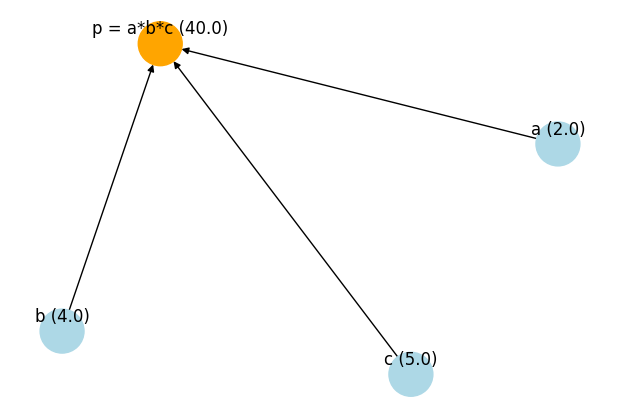

In [8]:
a = ConstantNode(2.0)
a._name = 'a'
b = ConstantNode(4.0)
b._name = 'b'
c = ConstantNode(5.0)
c._name = 'c'
p = ProductNode([a, b, c])
p._name = 'p'
print('product value =', p.value())

a_partial, b_partial, c_partial = p.local_partial_derivatives_wrt_arguments()
print('partial derivative wrt a =', a_partial)
print('partial derivative wrt b =', b_partial)
print('partial derivative wrt c =', c_partial)

# global derivatives of constants
print('global derivatives a=', a.global_derivative_wrt_self())
print('global derivatives b=', b.global_derivative_wrt_self())
print('global derivatives c=', c.global_derivative_wrt_self())
draw_graph(p, figsize=(6,4))
plt.show()


### Exercise 3: Not so simple function

From what you learnt earlier, try to create a computational graph for this function: $m = (a+b)\cdot(a+c)\cdot b$:
1. From what you learnt earlier, try to create a computational graph for this function: $m = (a+b)\cdot(a+c)\cdot b$:
2. In the Markdown Cell below, calculate the partial derivatives of $m$ wrt to $a$, $b$ and $c$. Calculate the global derivatives too.
4. Using the `draw_graph` function above, try to visualize the computational graph of $m = (a+b)\cdot(a+c)\cdot b$

**Your Solution to 2.**

Given:  
$ a = 2.0, \quad b = 3.0, \quad c = 3.0 $ and $ m = (a + b) \cdot (a + c) \cdot b $

**Step 1: We compute the value of $m$**  
$ m = (2.0 + 3.0) \cdot (2.0 + 3.0) \cdot 3.0 = 5.0 \cdot 5.0 \cdot 3.0 = 75.0 $

**Step 2: Partial derivatives**

$ \frac{\partial m}{\partial a} = b \big[(a + c) + (a + b)\big] = b(2a + b + c) $

$ \frac{\partial m}{\partial b} = (a + c)(a + b) + b(a + c) = (a + c)(a + 2b) $

$ \frac{\partial m}{\partial c} = (a + b)b $

**Step 3: We substitute values**

$ \frac{\partial m}{\partial a} = 3(2\cdot2 + 3 + 3) = 3(10) = 30 $

$ \frac{\partial m}{\partial b} = (2 + 3)(2 + 2\cdot3) = 5 \cdot 8 = 40 $

$ \frac{\partial m}{\partial c} = (2 + 3)\cdot 3 = 5 \cdot 3 = 15 $

**Step 4: Global derivatives:**  
$ \frac{dm}{da} = 30 $

$ \frac{dm}{db} = 40 $

$ \frac{dm}{dc} = 15 $


**Your solutions to 1. and 3. should go below:**

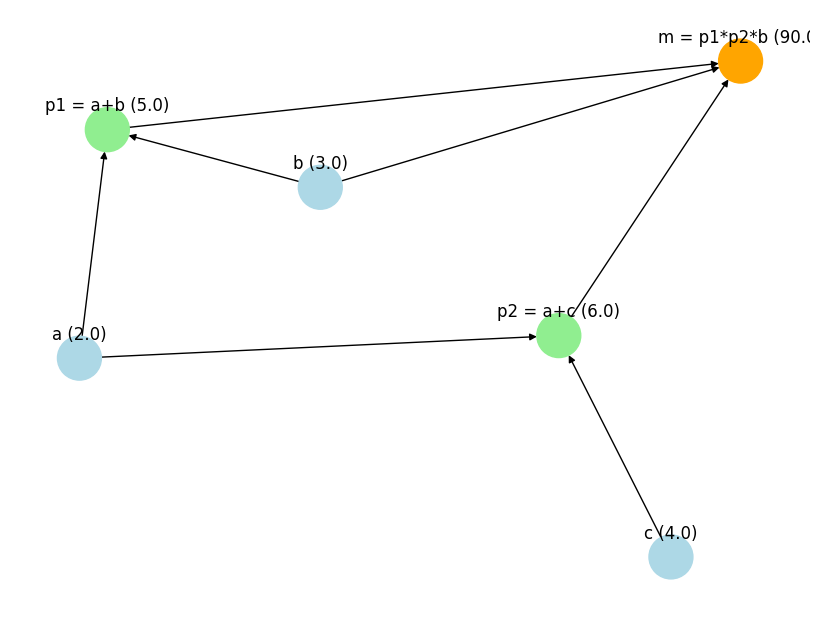

In [6]:
a = ConstantNode(2.0)
a._name = 'a'
b = ConstantNode(3.0)
b._name = 'b'
c = ConstantNode(4.0)
c._name = 'c'
p1 = SumNode([a, b])
p1._name = 'p1'
p2 = SumNode([a, c])
p2._name = 'p2'
m = ProductNode([p1, p2, b])
m._name = 'm'

draw_graph(m, figsize=(8,6))
plt.show()

### Exercise 4: Finally, an actual function!
- We want to implement $(a - x)^2 + b\cdot(y - x^2)^2$ (Rosenbrock Function) using constants, products and sums.
- Use these values: $a=1.0$, $b=1.5$, $x=-1.0$ and $y=0.5$
1. Like you did in previous exercises: Calculate the partial derivatives wrt $a$,$b$,$x$ and $y$, also the global derivatives.
2. Visualize the Rosenbrock Function

**Your solution to 1. should go below**

Given:  
$ a = 1.0, \quad b = 1.5, \quad x = -1.0, \quad y = 0.5 $ and $ f = (a - x)^2 + b \cdot (y - x^2)^2 $

**Step 1: Compute the value of $f$**  
$ f = (1.0 - (-1.0))^2 + 1.5 \cdot (0.5 - (-1.0)^2)^2 $

$ f = (2.0)^2 + 1.5 \cdot (0.5 - 1.0)^2 $

$ f = 4.0 + 1.5 \cdot (-0.5)^2 $

$ f = 4.0 + 1.5 \cdot 0.25 = 4.0 + 0.375 = 4.375 $

**Step 2: Partial derivatives**

$ \frac{\partial f}{\partial a} = 2(a - x) $

$ \frac{\partial f}{\partial b} = (y - x^2)^2 $

$ \frac{\partial f}{\partial x} = -2(a - x) - 4bx(y - x^2) $

$ \frac{\partial f}{\partial y} = 2b(y - x^2) $

**Step 3: Substitute the given values**

$ \frac{\partial f}{\partial a} = 2(1.0 - (-1.0)) = 2(2.0) = 4.0 $

$ \frac{\partial f}{\partial b} = (0.5 - (-1.0)^2)^2 = (0.5 - 1.0)^2 = (-0.5)^2 = 0.25 $

$ \frac{\partial f}{\partial x} = -2(1.0 - (-1.0)) - 4(1.5)(-1.0)(0.5 - (-1.0)^2) = -4 - 4(1.5)(-1.0)(-0.5) = -4 - 3.0 = -7.0 $

$ \frac{\partial f}{\partial y} = 2(1.5)(0.5 - (-1.0)^2) = 3(0.5 - 1.0) = 3(-0.5) = -1.5 $

**Step 4: Global derivatives**  
$ \frac{df}{da} = 4.0 $

$ \frac{df}{db} = 0.25 $

$ \frac{df}{dx} = -7.0 $

$ \frac{df}{dy} = -1.5 $


**Your solution to 2.** 

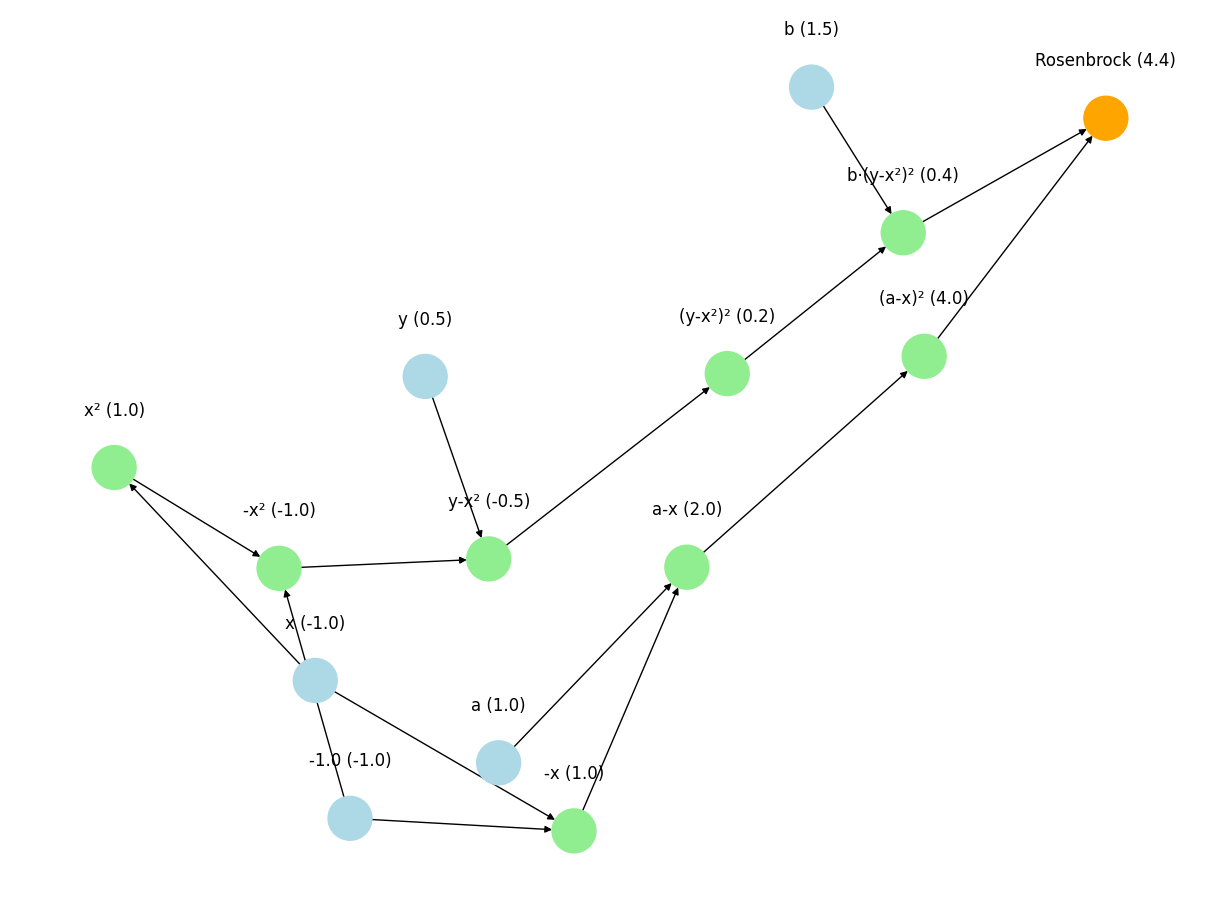

In [7]:
# defining constants
a = ConstantNode(1.0)
a._name = 'a'
b = ConstantNode(1.5)
b._name = 'b'
x = ConstantNode(-1.0)
x._name = 'x'
y = ConstantNode(0.5)
y._name = 'y'

# building (a-x)^2

minus_one = ConstantNode(-1.0)
minus_one._name = '-1.0'
neg_x = ProductNode([minus_one, x])
neg_x._name = '-x'
a_minus_x = SumNode([a, neg_x])
a_minus_x._name = 'a-x'
a_minus_x_squared = ProductNode([a_minus_x, a_minus_x])
a_minus_x_squared._name = '(a-x)²'

# building (y - x^2)^2
x_squared = ProductNode([x, x])
x_squared._name = 'x²'
neg_x_squared = ProductNode([minus_one, x_squared])
neg_x_squared._name = '-x²'
y_minus_x_squared = SumNode([y, neg_x_squared])
y_minus_x_squared._name = 'y-x²'
y_minus_x_squared_squared = ProductNode([y_minus_x_squared, y_minus_x_squared])
y_minus_x_squared_squared._name = '(y-x²)²'

# building b * (y - x^2)^2
b_times_y_minus_x_squared_squared = ProductNode([b, y_minus_x_squared_squared])
b_times_y_minus_x_squared_squared._name = 'b·(y-x²)²'

# building final sum
s = SumNode([a_minus_x_squared, b_times_y_minus_x_squared_squared])
s._name = 'Rosenbrock'

# graph

draw_graph(s, False,figsize=(12,9))
plt.show()
